#### - Sobhan Moradian Daghigh
#### 
#### - 1/5/2022
#### 
#### - ML - EX03 - Q1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

### Reading data

In [2]:
iris = datasets.load_iris()
dataset = pd.DataFrame(data= np.c_[iris.data, iris.target], columns= iris.feature_names + ['target'])
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


#### Ok. Lemme do a group by on the dataset for having 3 classes.

In [4]:
classes = dataset.groupby(by=dataset.iloc[:, -1])
classes.first()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
target,,,,,
0.0,5.1,3.5,1.4,0.2,0.0
1.0,7.0,3.2,4.7,1.4,1.0
2.0,6.3,3.3,6.0,2.5,2.0


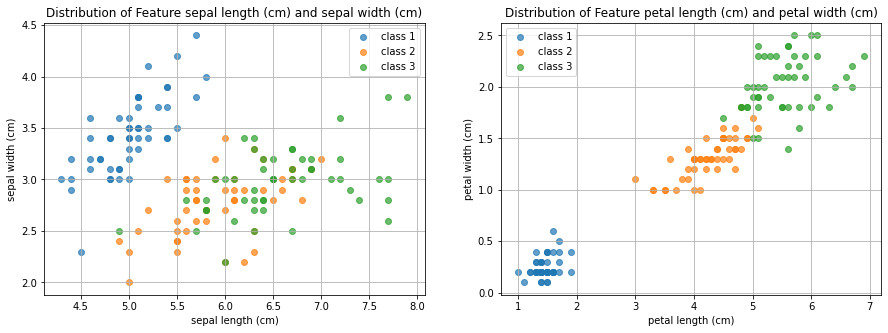

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
figs = [(0, 1), (2, 3)]
for i in range(2):
    for grp, pdf in classes:
        ax[i].scatter(pdf.iloc[:, figs[i][0]], pdf.iloc[:, figs[i][1]], alpha=0.7, label='class {}'.format((int(grp) + 1)))
        ax[i].legend()
        ax[i].grid()
        ax[i].set_title('Distribution of Feature {} and {}'.format(pdf.columns[figs[i][0]], pdf.columns[figs[i][1]]))
        ax[i].set_xlabel('{}'.format(pdf.columns[figs[i][0]]))
        ax[i].set_ylabel('{}'.format(pdf.columns[figs[i][1]]))

#### Splite the dataset into 80% of train and 20% of test.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], random_state = 10, test_size = 0.2)
train = pd.DataFrame(x_train)
test = pd.DataFrame(x_test)

In [7]:
def plotter(xx, yy, x_train, y_train, x_test, y_test, row, col, svms, kernel):
    print('SVMs for {} kernel:'.format(kernel))
    fig, ax = plt.subplots(row, col, figsize=(col * 7, row * 5))
    for i, clf in enumerate(svms):
        idx_x, idx_y = np.divmod(i, col)[0], np.divmod(i, col)[1]
        Z = clf[0].predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax[idx_x, idx_y].contourf(xx, yy, Z, alpha=0.8)

        ax[idx_x, idx_y].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.brg)
        ax[idx_x, idx_y].scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x')
        ax[idx_x, idx_y].set_xlabel('Sepal length')
        ax[idx_x, idx_y].set_ylabel('Sepal width')
        ax[idx_x, idx_y].set_xlim(xx.min(), xx.max())
        ax[idx_x, idx_y].set_ylim(yy.min(), yy.max())
        ax[idx_x, idx_y].grid()
        fig.tight_layout(pad=2)
        
        train_predictions = clf[0].predict(x_train)
        train_accuracy = round(accuracy_score(y_train, train_predictions), 3)
        train_f1score = round(f1_score(y_train, train_predictions, average='weighted'), 3)
        
        test_predictions = clf[0].predict(x_test)
        test_accuracy = round(accuracy_score(y_test, test_predictions), 3)
        test_f1score = round(f1_score(y_test, test_predictions, average='weighted'), 3)
        
        if kernel == 'linear':
            ax[idx_x, idx_y].set_title('linear - c:{}\n[train_acc:{} - test_acc:{}], [train_f1:{} - test_f1:{}]'
                                       .format(clf[1], train_accuracy, test_accuracy, train_f1score, test_f1score))
        elif kernel == 'poly':
            ax[idx_x, idx_y].set_title('poly - c:{} - degree:{}\n[train_acc:{} - test_acc:{}], [train_f1:{} - test_f1:{}]'
                                       .format(clf[2], clf[1], train_accuracy, test_accuracy, train_f1score, test_f1score))
        else:
            ax[idx_x, idx_y].set_title('{} - c:{} - gamma:{}\n[train_acc:{} - test_acc:{}], [train_f1:{} - test_f1:{}]'
                                       .format(kernel, clf[2], clf[1], train_accuracy, test_accuracy, train_f1score, test_f1score))
        
    plt.show()
    print('\n\n')

In [8]:
# transformer = Normalizer().fit(dataset.iloc[:, :2])
# normalized = pd.DataFrame(transformer.transform(dataset.iloc[:, :2]))
# normalized

#### Separate sepal length and sepal width

In [9]:
x_train = train.iloc[:, :2].values
x_test = test.iloc[:, :2].values

In [10]:
C = [0.01, 0.1, 1, 10, 100]
degree = [3, 4, 5]
gamma_rbf = [1, 3, 5, 7, 10]
gamma_sigmoid = [0.001, 0.003, 0.007, 0.01, 0.03]

In [11]:
h = .01  # step size in the mesh
x_min, x_max = x_train[:, 0].min() - 0.2, x_train[:, 0].max() + 0.2
y_min, y_max = x_train[:, 1].min() - 0.2, x_train[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

SVMs for linear kernel:


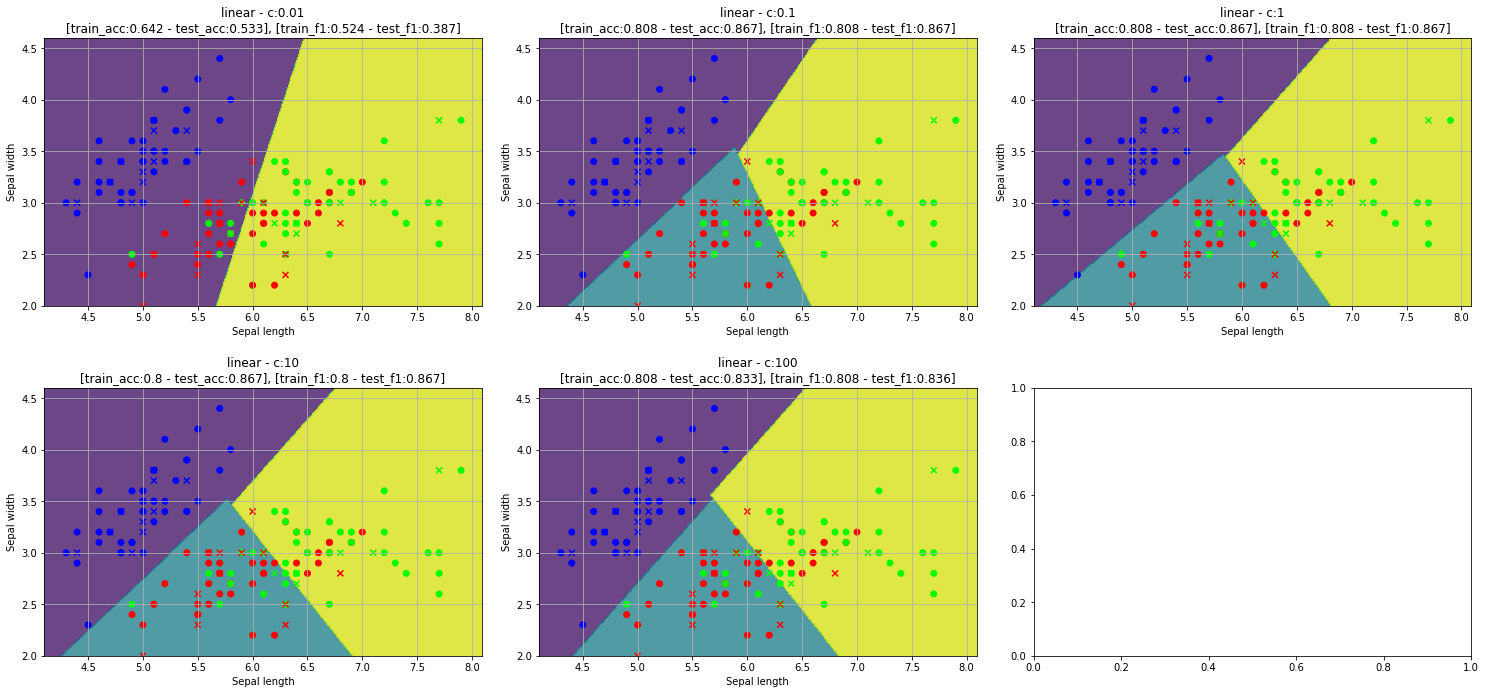




SVMs for poly kernel:


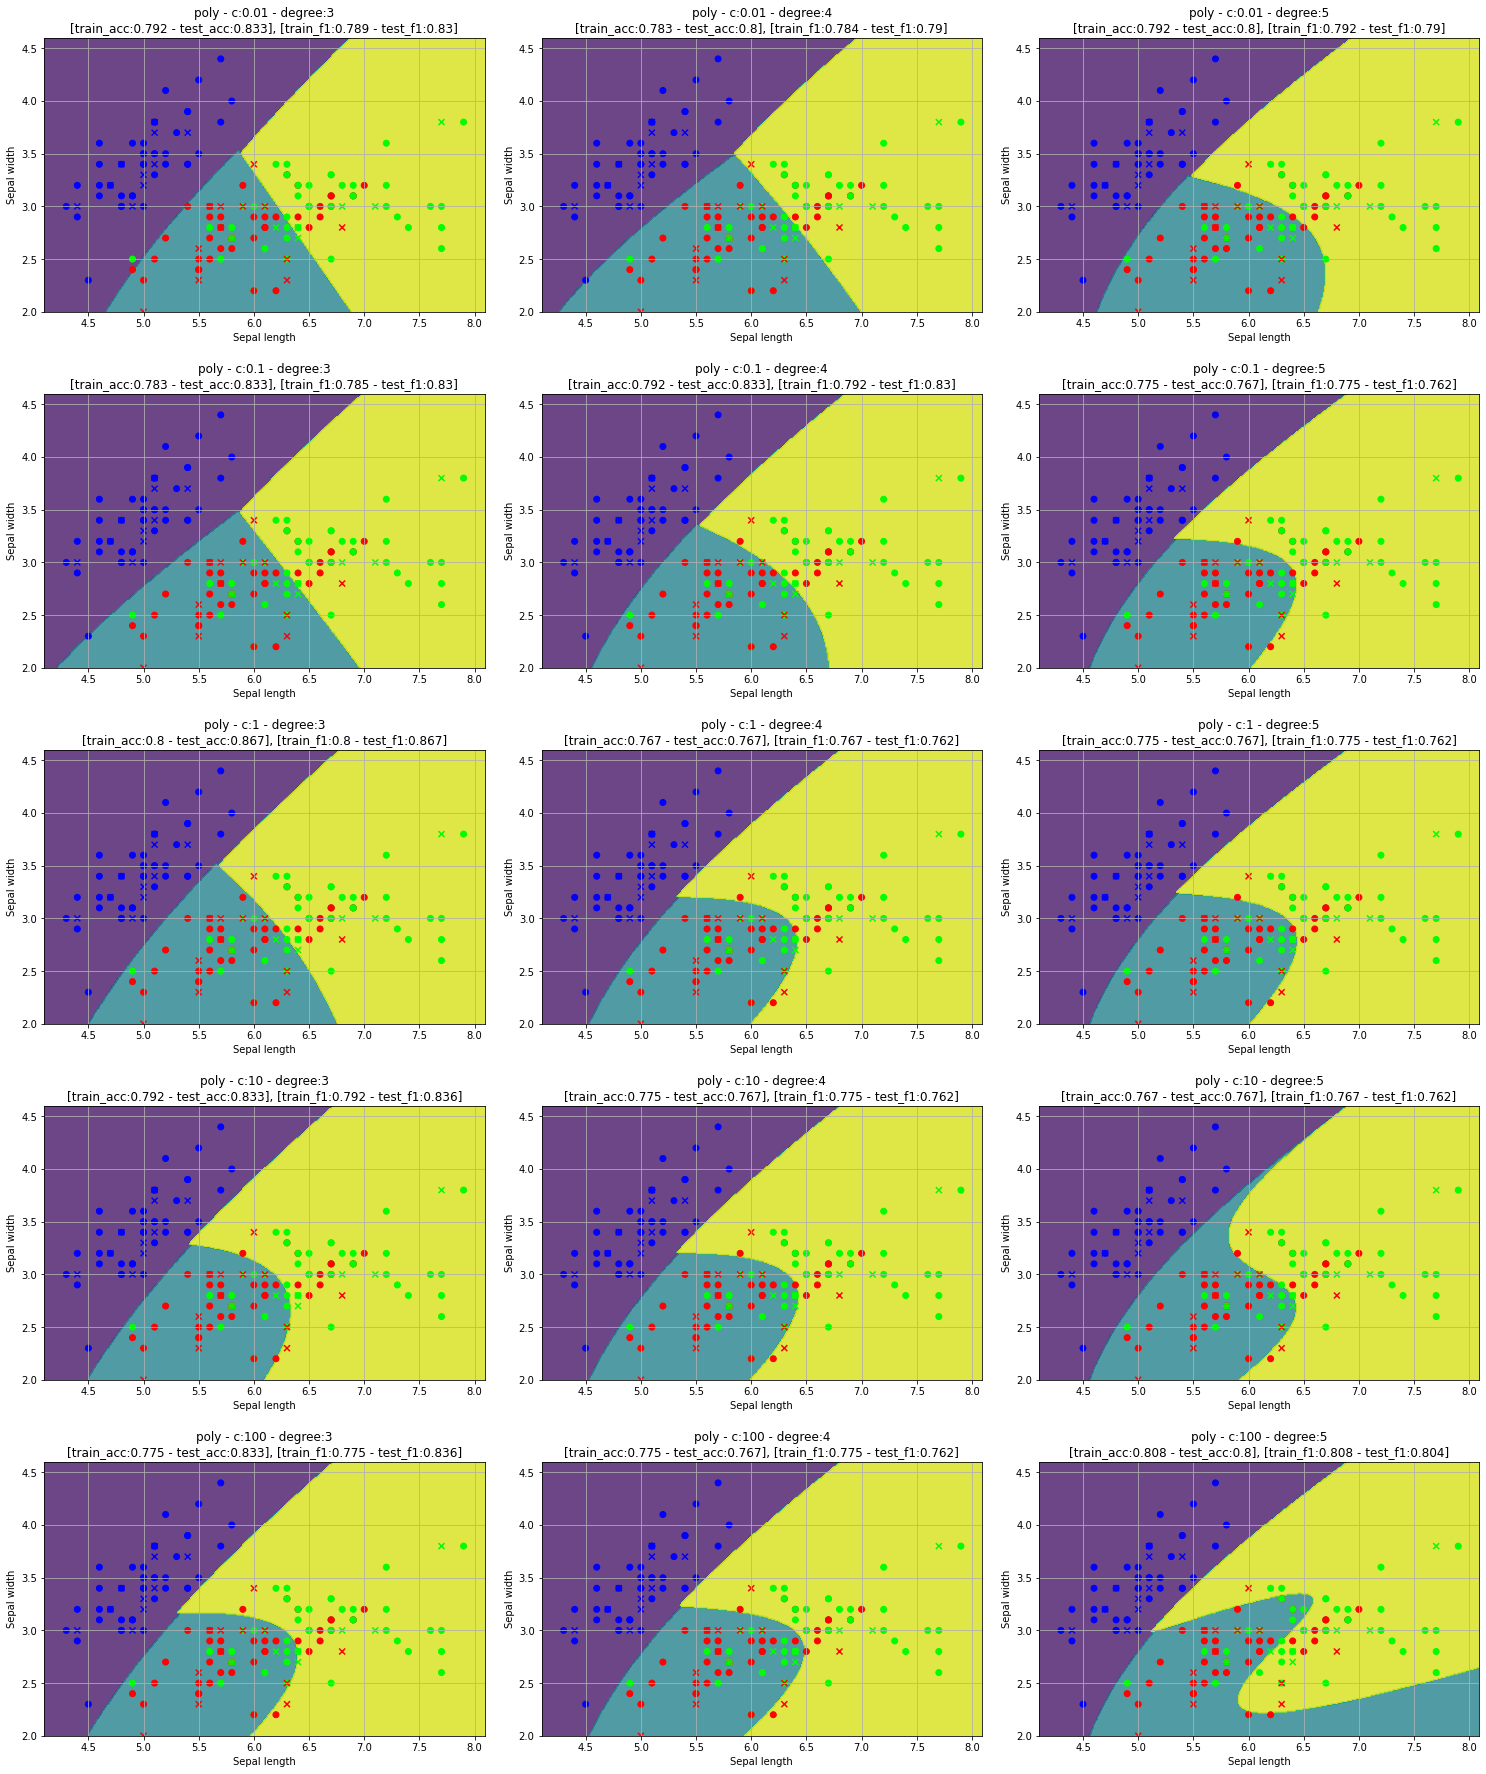




SVMs for rbf kernel:


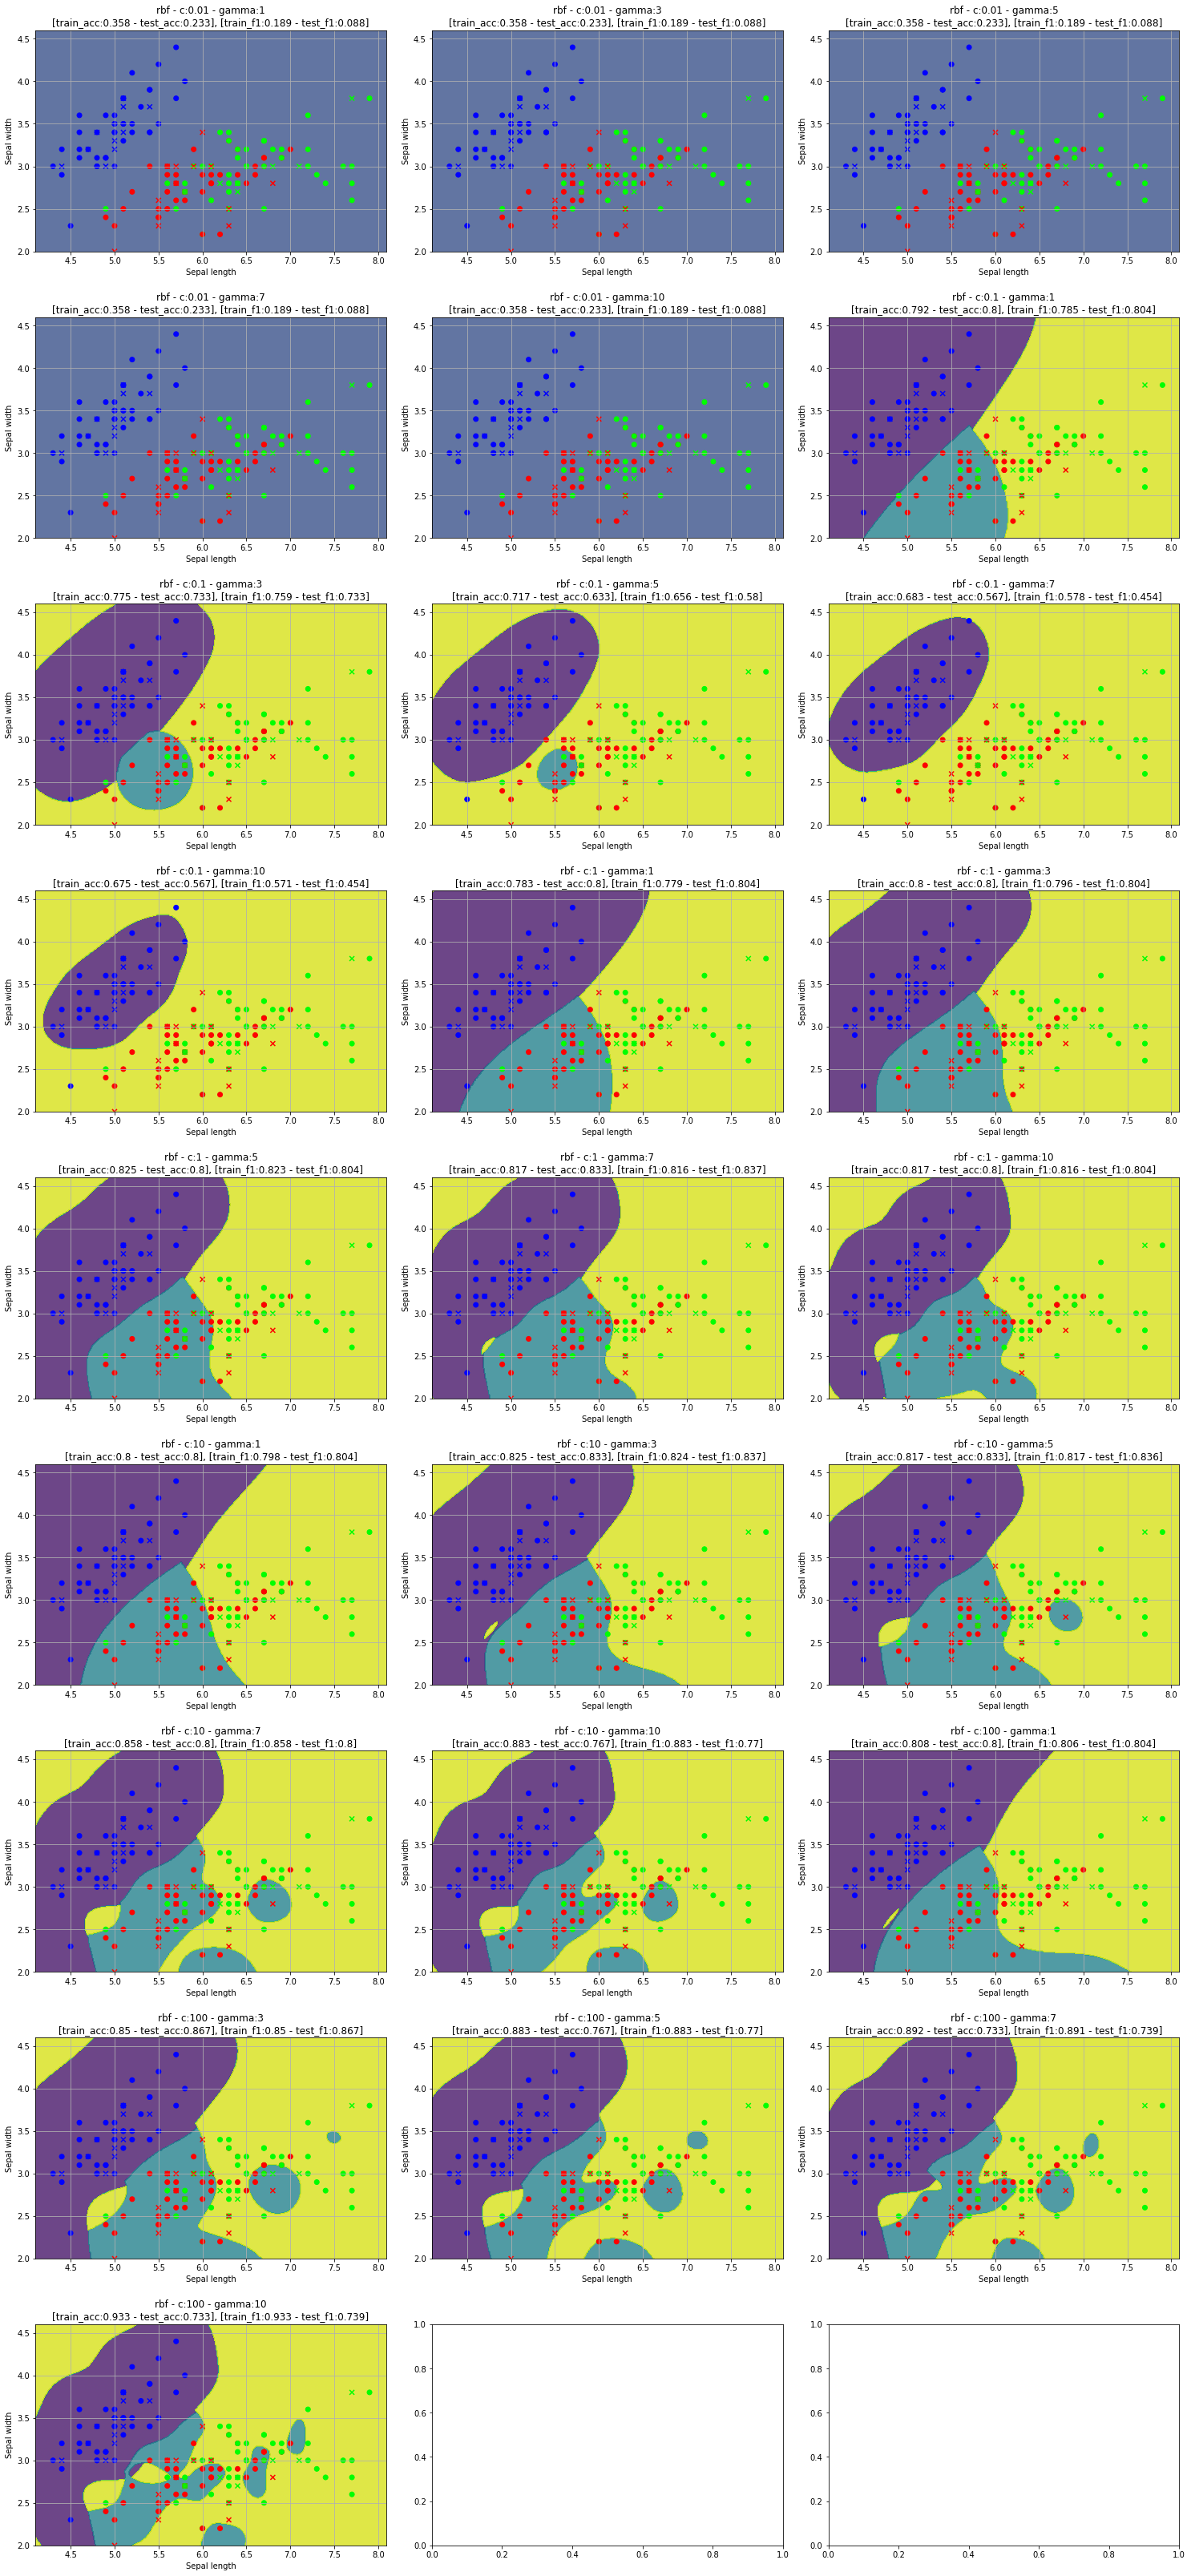




SVMs for sigmoid kernel:


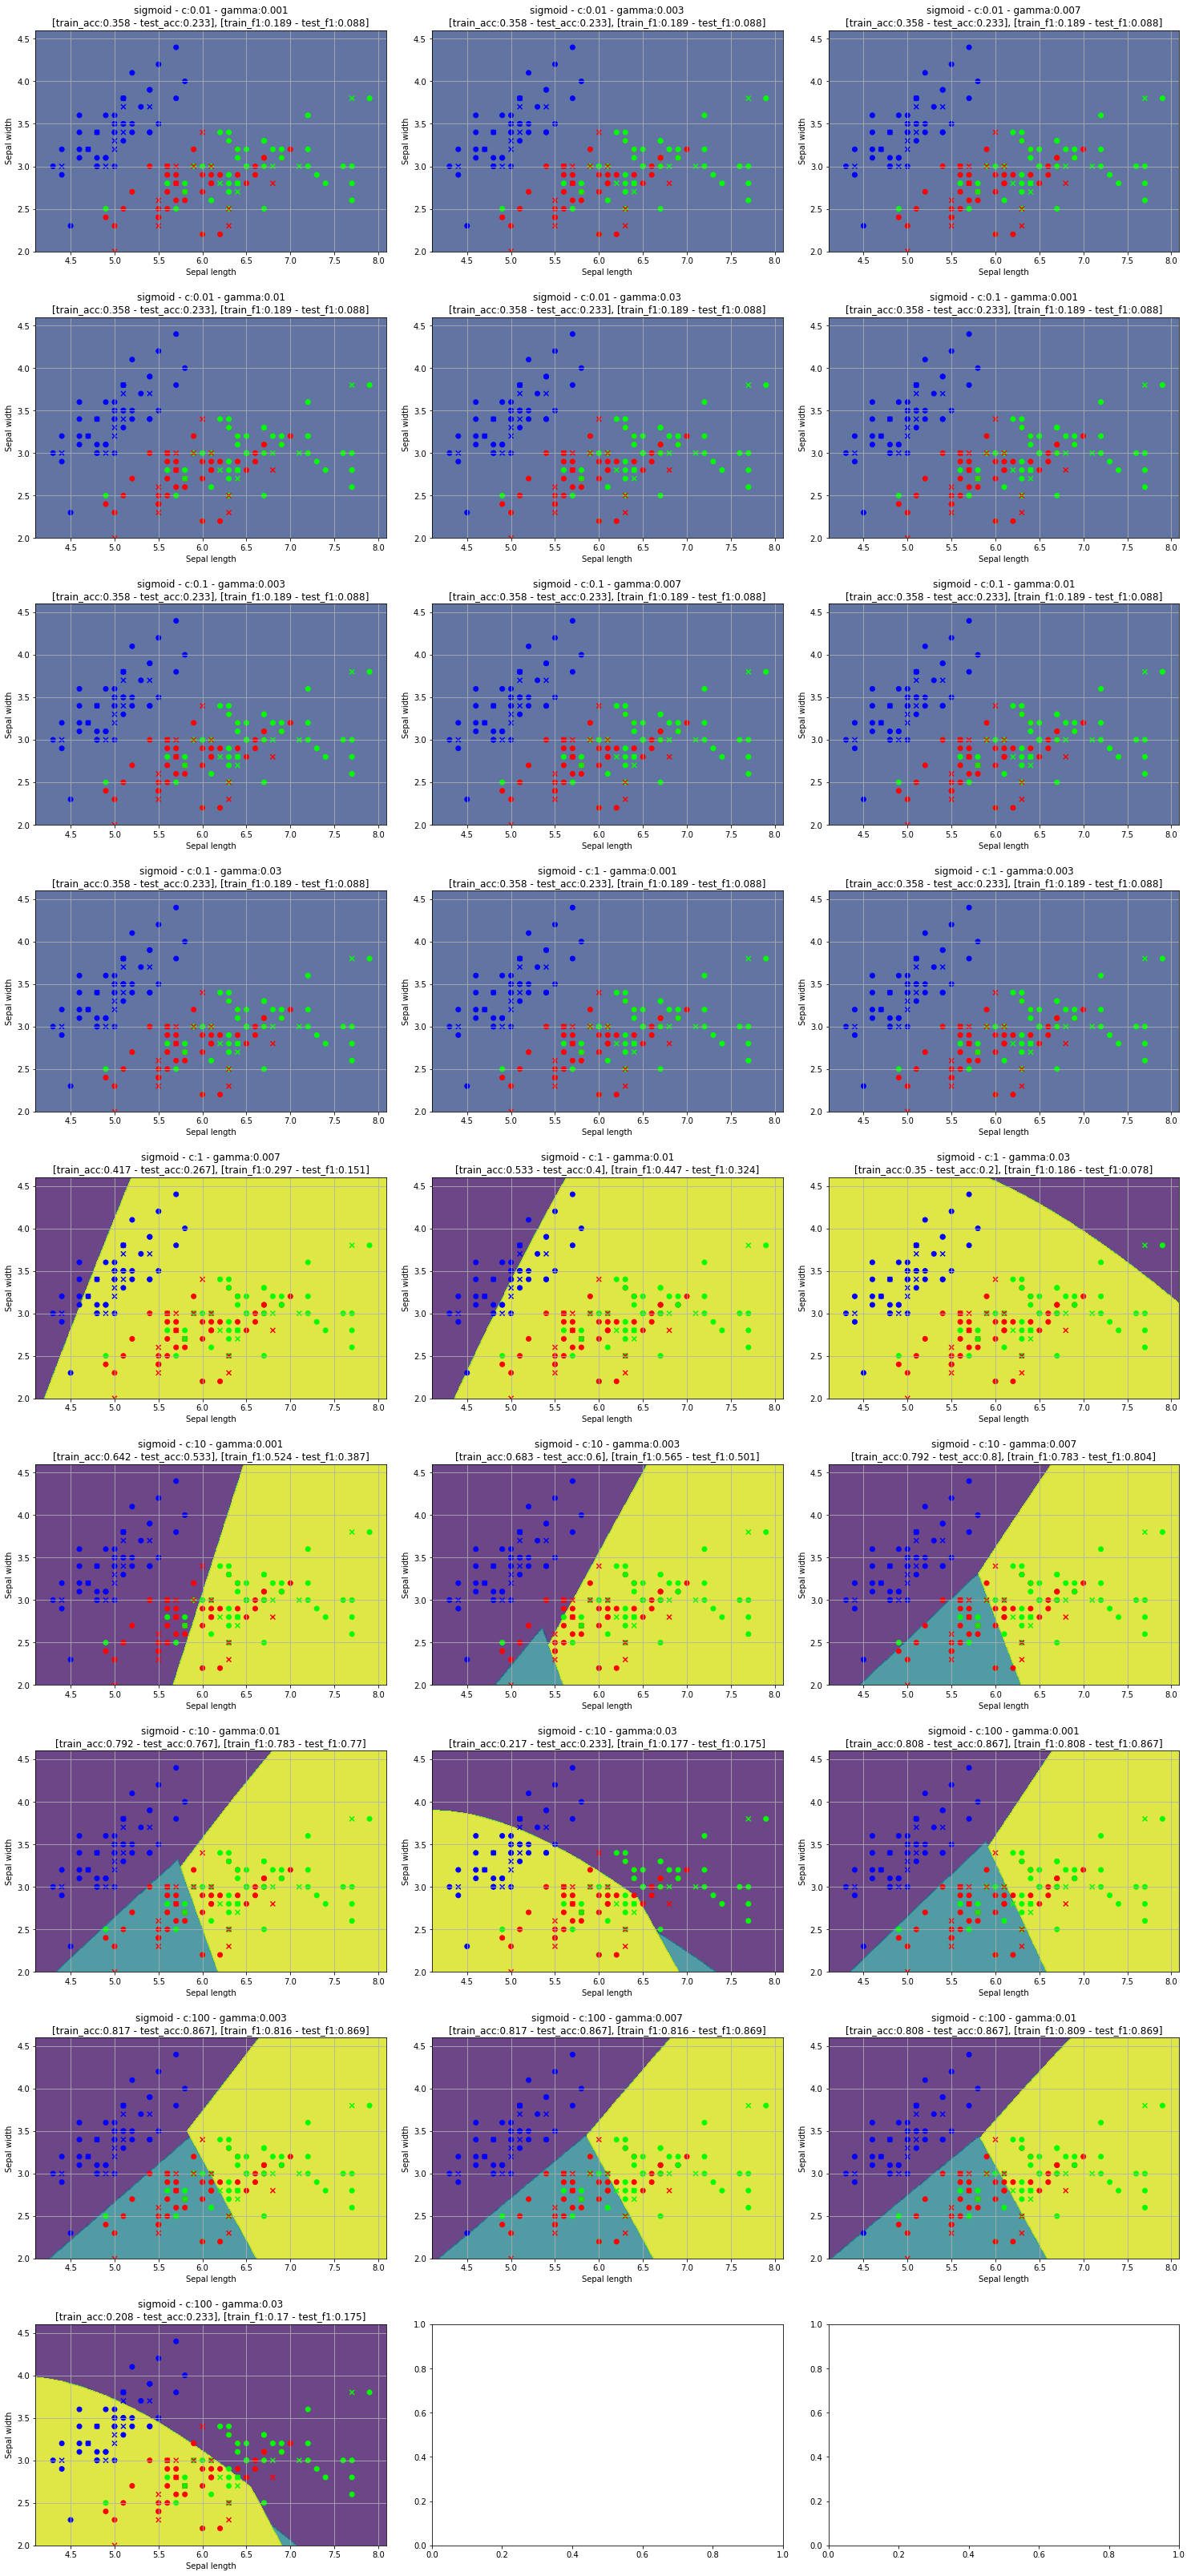

In [12]:
linear_svms = []
poly_svms = []
rbf_svms = []
sigmoid_svms = []

for c in C:
    linear_svc = svm.SVC(kernel='linear', C=c).fit(x_train, y_train)
    linear_svms.append([linear_svc, c])
    
    for deg in degree:
        poly_svc = svm.SVC(kernel='poly', degree=deg, C=c).fit(x_train, y_train)
        poly_svms.append([poly_svc, deg, c])
        
    for gam in gamma_rbf:
        rbf_svc = svm.SVC(kernel='rbf', gamma=gam, C=c).fit(x_train, y_train)
        rbf_svms.append([rbf_svc, gam, c])
        
    for gam in gamma_sigmoid:
        sigmoid_svc = svm.SVC(kernel='sigmoid', gamma=gam, C=c).fit(x_train, y_train)
        sigmoid_svms.append([sigmoid_svc, gam, c])
    
plotter(xx, yy, x_train, y_train, x_test, y_test, int(np.ceil(len(linear_svms) / 3)), 3, linear_svms, kernel='linear')
plotter(xx, yy, x_train, y_train, x_test, y_test, int(np.ceil(len(poly_svms) / 3)), 3, poly_svms, kernel='poly')
plotter(xx, yy, x_train, y_train, x_test, y_test, int(np.ceil(len(rbf_svms) / 3)), 3, rbf_svms, kernel='rbf')
plotter(xx, yy, x_train, y_train, x_test, y_test, int(np.ceil(len(sigmoid_svms) / 3)), 3, sigmoid_svms, kernel='sigmoid')


In [13]:
tuned_parameters = [
    {"kernel": ["linear"], "C": C},
    {"kernel": ["poly"], "degree": degree, "C": C},
    {"kernel": ["rbf"], "gamma": gamma_rbf, "C": C},
    {"kernel": ["sigmoid"], "gamma": gamma_sigmoid, "C": C},
]

In [14]:
clf = GridSearchCV(svm.SVC(), tuned_parameters, verbose=1)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Best parameters set found on development set:

{'C': 100, 'gamma': 0.003, 'kernel': 'sigmoid'}
0.8083333333333333


In [15]:
results = pd.DataFrame(clf.cv_results_)
results = results.reset_index().sort_values(['rank_test_score', 'index'])
results.reset_index(inplace=True)
pd.DataFrame([results.loc[:, x] for x in ['params', 'mean_test_score']]).T.head(10)

,params,mean_test_score
0,"{'C': 100, 'gamma': 0.003, 'kernel': 'sigmoid'}",0.808333
1,"{'C': 100, 'gamma': 0.007, 'kernel': 'sigmoid'}",0.8
2,"{'C': 100, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.8
3,"{'C': 100, 'degree': 4, 'kernel': 'poly'}",0.791667
4,"{'C': 100, 'degree': 5, 'kernel': 'poly'}",0.791667
5,"{'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.791667
6,"{'C': 0.1, 'kernel': 'linear'}",0.783333
7,"{'C': 1, 'degree': 5, 'kernel': 'poly'}",0.783333
8,"{'C': 10, 'degree': 5, 'kernel': 'poly'}",0.783333
9,"{'C': 1, 'kernel': 'linear'}",0.783333
